In [1]:
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from data.generator import *
from data import filters
from data import utils
%precision 4
%matplotlib inline
#%matplotlib notebook

## Regulation charts

### EWMA charts (exponentially weighted moving average chart)
 - type of control chart used to monitor variables
 - regulations are given by:
 $$T \pm L\frac {S}{\sqrt n}\sqrt{\frac{\lambda}{2 - \lambda}\lbrack 1 - \left ( 1 - \lambda \right )^{2i} \rbrack}$$

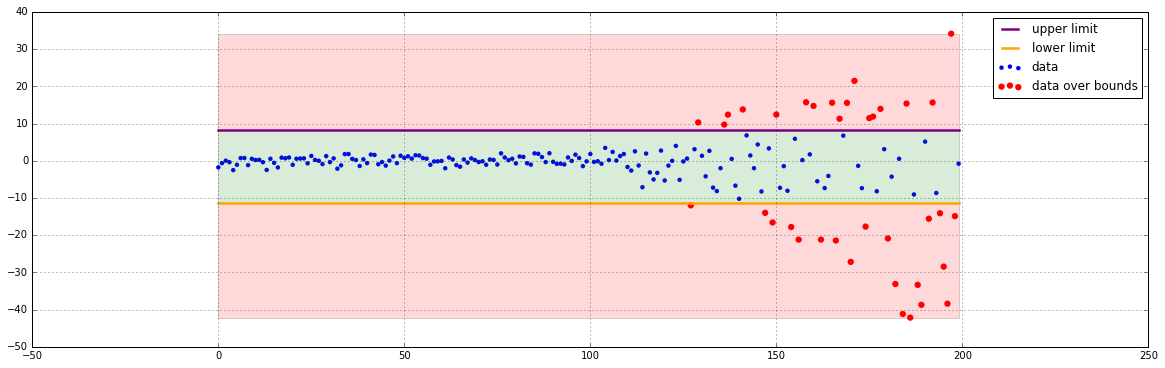

In [2]:
# ewma example
size  = 200
mu    = 0
sigma = 1

lam   = 0.2 # λ, the weight given to the most recent rational subgroup mean
L     = 3   # the multiple of the rational subgroup standard deviation that establishes the control limits
# ---------------------
data = generate([
    DataConfig(int(size/2), constant_generator(mu, sigma)),
    DataConfig(size - int(size/2), spread_generator(mu, sigma, sigma/5))
])
n = len(data[0])
# ---------------------

# get ucl, lcl and filter data
ucl, lcl = filters.ewma_variance(*data, lam=lam, L=L)
overs = filters.outside_bounds(*data, ucl=ucl, lcl=lcl)

plt.figure(figsize=(20,6))
plt.grid(True)
plt.scatter(*data, c='blue', edgecolor='none', label='data')


# plot ucl and lcl
plt.plot(*ucl, c='purple', lw=2.5, label='upper limit')
plt.plot(*lcl, c='orange', lw=2.5, label='lower limit')

# draw regions
plt.fill_between(data[0], ucl[1], lcl[1], facecolor='green', alpha=0.15)
plt.fill_between(data[0], ucl[1], [max(data[1])]*n, facecolor='red', alpha=0.15)
plt.fill_between(data[0], lcl[1], [min(data[1])]*n, facecolor='red', alpha=0.15)

# scatter "wrong" point
plt.scatter(*overs, c='r', edgecolor='none', label='data over bounds', marker='o', s=40)
plt.legend();

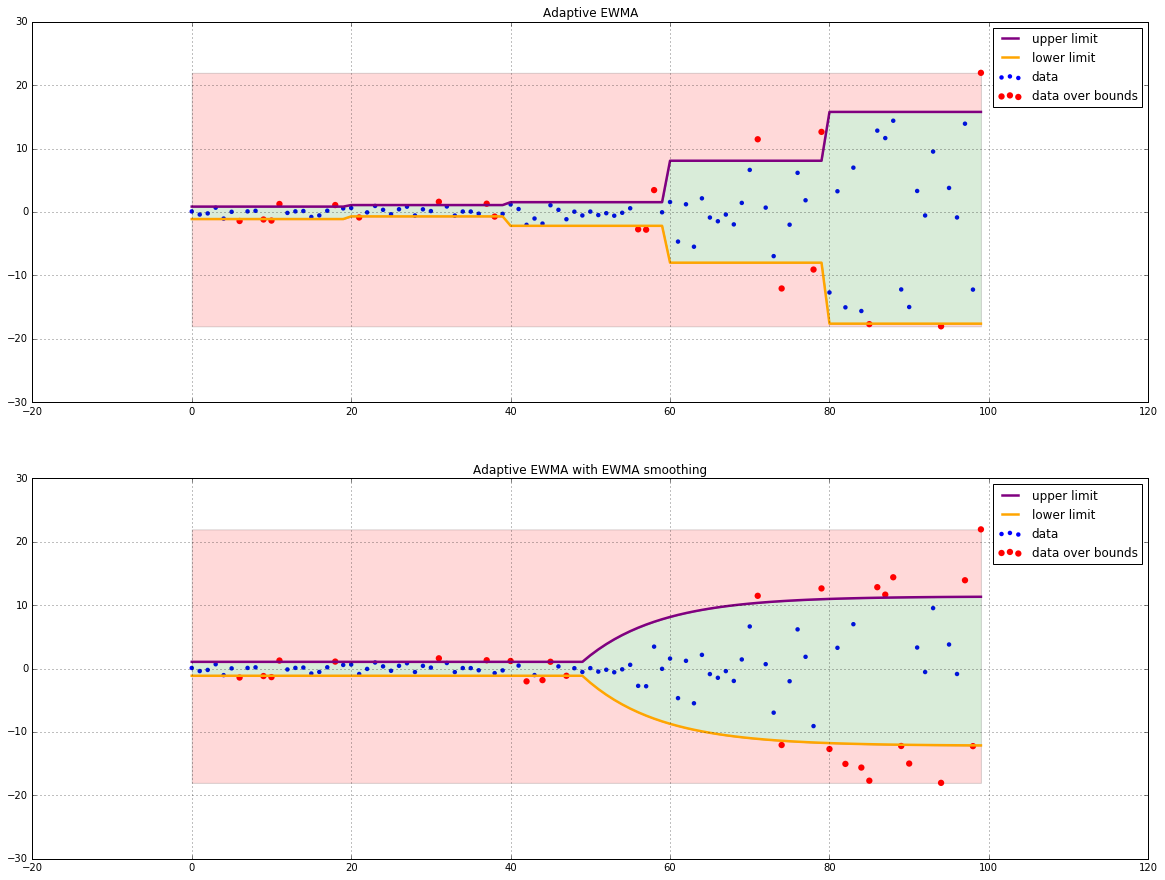

In [3]:
# ewma example
size  = 100
mu    = 0
sigma = 1

lam   = 0.2 # λ, the weight given to the most recent rational subgroup mean
L     = 3   # the multiple of the rational subgroup standard deviation that establishes the control limits
# ---------------------
data = generate([
    DataConfig(int(size/2), constant_generator(mu, sigma)),
    DataConfig(size - int(size/2), spread_generator(mu, sigma, sigma/5))
])
# ---------------------

def experiment(data, ucl, lcl, title):
    n = len(data[0])
    overs = filters.outside_bounds(*data, ucl=ucl, lcl=lcl)
    
    # start plotting
    plt.grid(True)
    plt.scatter(*data, c='blue', edgecolor='none', label='data')

    # plot ucl and lcl
    plt.plot(*ucl, c='purple', lw=2.5, label='upper limit')
    plt.plot(*lcl, c='orange', lw=2.5, label='lower limit')

    plt.fill_between(data[0], ucl[1], lcl[1], facecolor='green', alpha=0.15)
    plt.fill_between(data[0], ucl[1], [max(data[1])]*n, facecolor='red', alpha=0.15)
    plt.fill_between(data[0], lcl[1], [min(data[1])]*n, facecolor='red', alpha=0.15)

    # scatter "wrong" point
    
    plt.scatter(*overs, c='r', edgecolor='none', label='data over bounds', marker='o', s=40)
    plt.title(title)
    plt.legend();
# ----------------------------------------------------------------------------------------

L = 4
lam = 0.2
# plot setup
plt.figure(figsize=(20,15))

# get ucl, lcl and filter data
plt.subplot(2, 1, 1)
ucl, lcl = filters.ewma_adaptive_variance_linear(*data, lam=lam, L=L, l=20)
experiment(data, ucl, lcl, 'Adaptive EWMA')


# get ucl, lcl and filter data
plt.subplot(2, 1, 2)
ucl, lcl = filters.ewma_adaptive_variance_linear(*data, lam=lam, L=L, l=50)
ucl = filters.ewma_filter(*ucl)
lcl = filters.ewma_filter(*lcl)
experiment(data, ucl, lcl, 'Adaptive EWMA with EWMA smoothing')


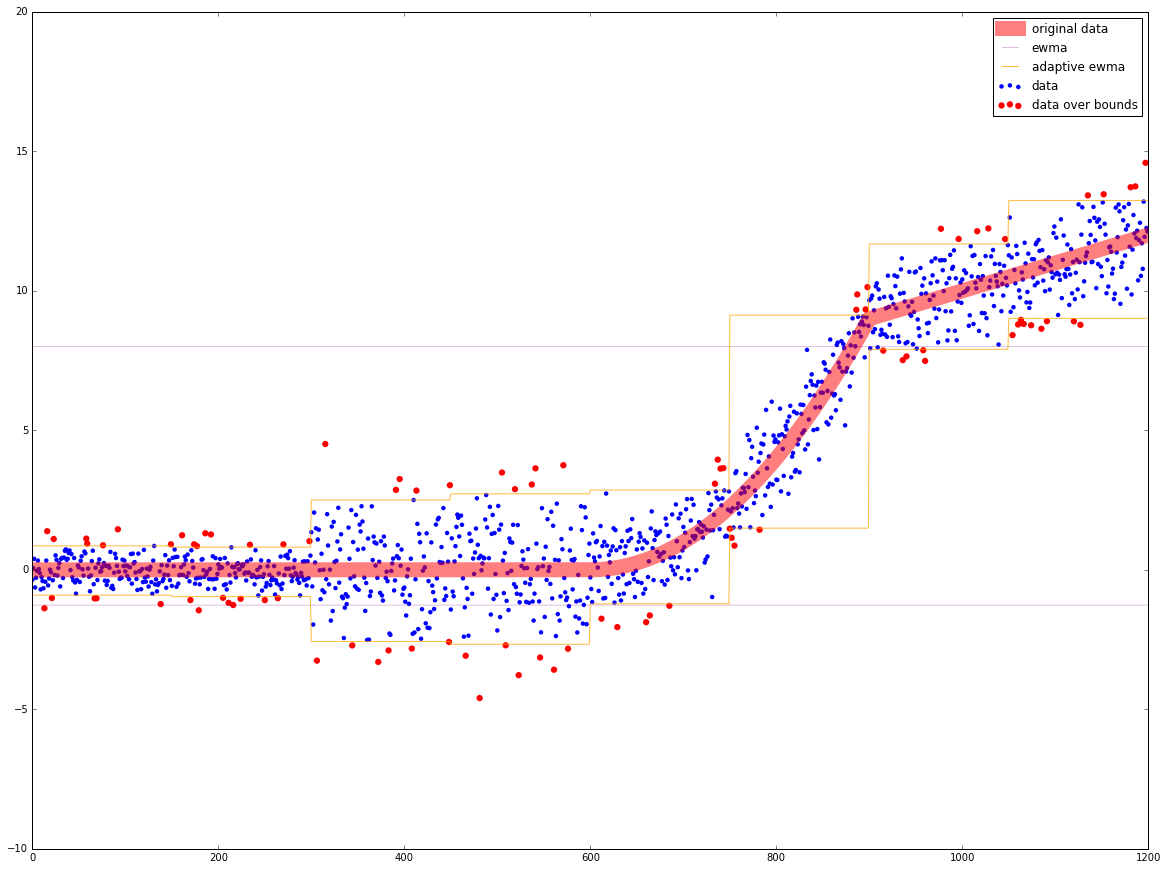

In [4]:
size = 300
data = generate(
    [
        DataConfig(size, constant_generator(sigma=0.5)),
        DataConfig(size, constant_generator(sigma=1.5)),
        DataConfig(size, exponential_generator(scale=0.0001)),
        DataConfig(size, linear_generator(scale=0.01), start=int(size*size*0.01))
    ]
)

original = generate(
    [
        DataConfig(size, constant_generator(sigma=0.00001)),
        DataConfig(size, constant_generator(sigma=0.00001)),
        DataConfig(size, exponential_generator(scale=0.0001, sigma=0.00001)),
        DataConfig(size, linear_generator(scale=0.01, sigma=0.00001), start=int(size*size*0.01))
    ]
)

# generate data
sma_data = filters.sma_filter(*data)
maww_data = filters.maww_filter(*data)
ewma_data = filters.ewma_filter(*data)
des_data = filters.des_filter(*data)
des_ewma_data = filters.combine_filter(filters.des_filter, filters.ewma_filter)(*data)
sc = dict(edgecolors='none')


# plot data and filtered data
plt.figure(figsize=(20,15))
plot(data,      'blue',     'scatter', label='data', **sc)
plot(original,  'red',      'plot', label='original data', lw=15, alpha=0.5)
if 0:
    plot(sma_data,  'red',      'plot', label='sma')
    plot(maww_data, 'green',    'plot', label='maww')
    plot(ewma_data, 'black',    'plot', label='ewma')
    plot(des_data,  'brown',    'plot', label='des')
    plot(des_ewma_data, 'pink', 'plot', label='des and ewma')

    
    
control_chart_data = data


if 1:
    # plot control chart
    ucl, lcl = filters.ewma_variance(*control_chart_data)
    plot(ucl, 'purple', 'plot', alpha=0.25, label='ewma')
    plot(lcl, 'purple', 'plot', alpha=0.25)

    # dynamic controls
    ducl, dlcl = filters.ewma_adaptive_variance_linear(*control_chart_data, l=150)
    #ducl, dlcl = filters.ewma_filter(*ducl), filters.ewma_filter(*dlcl)
    #ducl, dlcl = filters.sma_filter(*ducl), filters.sma_filter(*dlcl)
    plot(ducl, 'orange', 'plot', alpha=0.75, label='adaptive ewma')
    plot(dlcl, 'orange', 'plot', alpha=0.75)
    
    overs = filters.outside_bounds(*data, ucl=ducl, lcl=dlcl)
    plt.scatter(*overs, c='r', edgecolor='none', label='data over bounds', marker='o', s=40)


ax = plt.gca()
ax.set_xlim(0, len(data[0]))
plt.legend();